In [1]:
%load_ext autoreload
%autoreload 2

# Systematically Improving Your Rag Application

## Why use LLM generated metadata

Customers will ask questions that require metadata filters to answer correctly. For instance, a customer might ask - **What red dresses might be good for a black and white event** or **What shoes might go well with a white oversized shirt and white chino pants**. These are questions that require metadata filters to answer correctly. We'll need to capture information such as

- Category : What does an item fall under (Eg. Dresses, Shoes)
- Color : What is the color of an item (Eg. Red, Black)
- Occasion: What occasions does this item go well with

We want to use LLMs to generate metadata because they significantly reduce the effort required to generate high-quality metadata. These metadata fields act like materialized views and allows us to support significantly more complex queries over time.

## Fashion RAG

In this notebook, we'll ingest in some data and build out a small RAG application which allows people to get clothing recomendations when they describe an item they like. They'll then be able to get the items in stock based on their preferences. To do so, we'll be using a dataset that we've processed and cleaned ahead of time - `ivanleomk/ecommerce-items`. 

This dataset contains the following fields
- `id` : An id that identifies each unique item
- `image`: An image of a model wearing the item
- `description` : The description of the item on the store front
- `title`: The title of the item
- `brand`: The specific brand which it is from

We want to generate metadata to support customer queries. We'll do so in 3 steps

1. **Generate Metadata**: We'll first define a few metadata filters that we want to support andthen use an LLM to generate the metadata for each item.
2. **Query Understanding** : Next using instructor, we'll map customer queries over to the metadata filters that we've created. This will allow us to filter on the items that we care about
3. **Generate Questions** : Lastly, we'll define some synthetic questions that we can use to evaluate these items and see how metadata search improves the quality of our returned results

Throughout this process, we'll use `braintrust` to collect the data and measure improvements. Braintrust makes it easy to collaborate with a team and simplifies data collection and evaluation.


In [2]:
from datasets import load_dataset

ds = load_dataset("ivanleomk/ecommerce-items")

/Users/ivanleo/Documents/coding/systematically-improving-rag/cohort_2/week5/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
ds["train"][0]["title"], ds["train"][0]["description"]

('Teal Lace Top',
 'Elevate your wardrobe with this chic teal lace top, perfect for any occasion. The delicate lace detailing adds a touch of elegance and sophistication to your everyday look.')

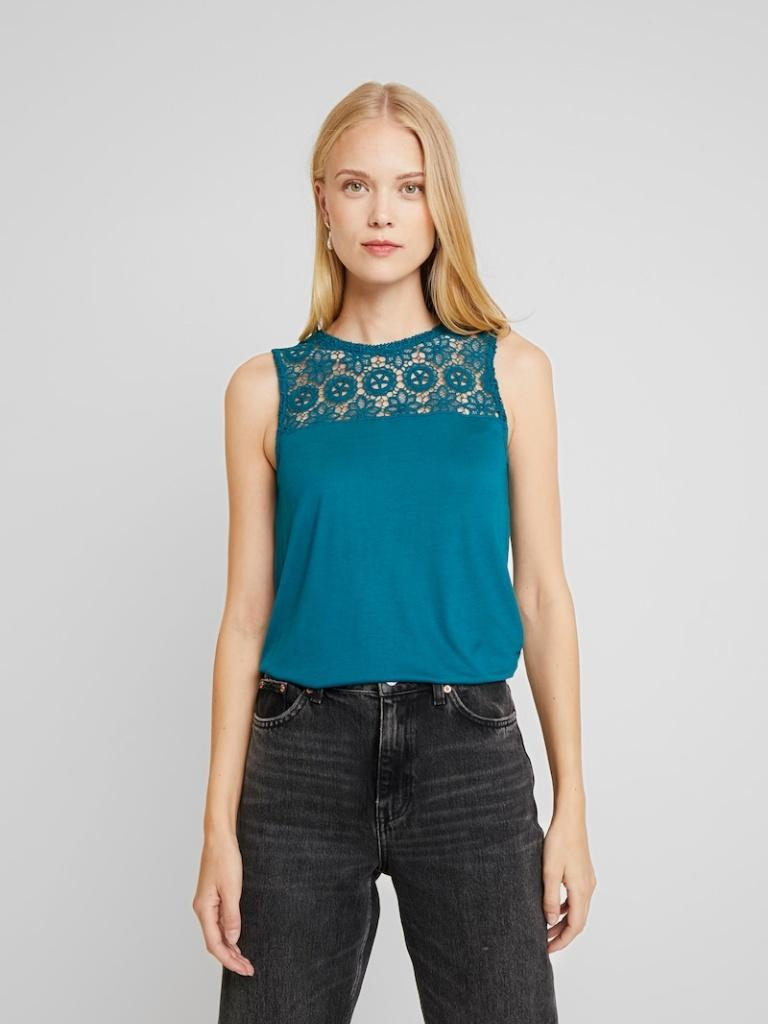

In [ ]:
ds["train"][0]["image"]

In [32]:
from instructor import from_openai
from openai import AsyncOpenAI
from pydantic import BaseModel
from rich import print
from asyncio import timeout, Semaphore
import tempfile
import instructor
from tenacity import retry, wait_fixed, stop_after_attempt
import random


client = from_openai(AsyncOpenAI())


class SyntheticQuestion(BaseModel):
    question: str
    expected_answer: str

@retry(wait=wait_fixed(2), stop=stop_after_attempt(3))
async def generate_synthetic_question(row, sem:Semaphore):
    with tempfile.NamedTemporaryFile(delete_on_close=True, suffix=".jpg") as f:
        image = row["image"]
        title = row["title"]
        description = row["description"]
        image.save(f.name)

        user_intent = random.choice([
            "buying an outfit for an occasion (Eg. I need a shirt that's suitable for a black tie event)",
            "looking to get something that might match an existing outfit of theirs (Eg. I have a cute lace skirt that I need a top for, it's green and I want something that will look nice with it)",
            "looking for an item with a specific property (Eg. I want skirts that are made of silk which are in size M)"
        ])

        async with sem, timeout(30):
            resp = await client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": [
                            f"Generate a question that a user {user_intent} would ask which the following item of {title} and {description} would be a good fit for. The item should be uniquely suited for this role. It's ok to mention some properties of the image",
                            instructor.Image.from_path(f.name),
                        ],
                    }
                ],
                model="gpt-4o",
                response_model=SyntheticQuestion,
            )

            # Store the result in the desired format
            return {"question": resp.question, "row_id": row["id"]}

sem = Semaphore(4)

question = await generate_synthetic_question(ds["train"][0],sem)
print(question)

{
    'question': "I'm looking for a chic top in teal with delicate lace detailing that's perfect for elevating my 
wardrobe. Do you have any recommendations?",
    'row_id': 0
}

In [35]:
from tqdm.asyncio import tqdm_asyncio as asyncio
sem = Semaphore(10)
questions = [
   generate_synthetic_question(item,sem) for item in ds['train'].take(80)
]


generated_questions = await asyncio.gather(*questions)

100%|██████████| 80/80 [00:32<00:00,  2.49it/s]


In [41]:
import json
with open("./questions.jsonl","w+") as f:
    for item in generated_questions:
        f.write(json.dumps(item))

In [36]:
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry

db = lancedb.connect("./lance")
func = get_registry().get("openai").create(name="text-embedding-3-small")


class Item(LanceModel):
    id: int
    text: str = func.SourceField()
    vector: Vector(func.ndims()) = func.VectorField()


if "descriptions" not in db.table_names():
    table = db.create_table("descriptions", schema=Item, mode="overwrite")

    items = [{"id": row["id"], "text": row["description"]} for row in ds["train"]]

    table.add(items)
else:
    table = db.open_table("descriptions")

In [37]:
from braintrust import Eval, Score
from helpers import get_metrics_at_k, task



def evaluate_braintrust(input, output, **kwargs):
    metrics = get_metrics_at_k(metrics=["mrr", "recall"], sizes=[1, 3, 5,10,15,25])
    return [
        Score(
            name=metric,
            score=score_fn(output, kwargs["expected"]),
            metadata={"query": input, "result": output, **kwargs["metadata"]},
        )
        for metric, score_fn in metrics.items()
    ]


await Eval(
    "filters",  
    data=lambda: [
        {
            "input": question['question'],
            "expected": [question['row_id']],
        }
        for question in generated_questions
    ],  # Replace with your eval dataset
    task=lambda query: task(
        user_query=query, table=table, reranker=None, max_k=25
    ),  # Replace with your LLM call
    scores=[evaluate_braintrust],
)

Experiment main-1732799221 is running at https://www.braintrust.dev/app/567/p/filters/experiments/main-1732799221
filters (data): 80it [00:00, 62160.86it/s]
filters (tasks): 100%|██████████| 80/80 [00:04<00:00, 16.61it/s]



=========================SUMMARY=========================
main-1732799221 compared to main-1732799054:
41.25% 'mrr@1'     score
50.83% 'mrr@3'     score
51.90% 'mrr@5'     score
53.11% 'mrr@10'    score
53.19% 'mrr@15'    score
53.32% 'mrr@25'    score
41.25% 'recall@1'  score
61.25% 'recall@3'  score
66.25% 'recall@5'  score
75.00% 'recall@10' score
76.25% 'recall@15' score
78.75% 'recall@25' score

1.32s duration

See results for main-1732799221 at https://www.braintrust.dev/app/567/p/filters/experiments/main-1732799221


EvalResultWithSummary(summary="...", results=[...])

In [28]:
import io

def convert_to_bytes(image):
    byte_data = io.BytesIO()
    image.save(byte_data, format='JPEG')
    byte_data = byte_data.getvalue()
    return byte_data

In [39]:
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry

db = lancedb.connect("./lance")
func = get_registry().get("open-clip").create()

class Item(LanceModel):
    id: int
    image: bytes = func.SourceField()
    description: str 
    vector: Vector(func.ndims()) = func.VectorField()


if "images" not in db.table_names():
    table = db.create_table("images", schema=Item, mode="overwrite")

    items = [{"id": row["id"], "description": row["description"], "image": convert_to_bytes(row['image'])} for row in ds["train"]]

    table.add(items)
else:
    table = db.open_table("images")

In [40]:
from braintrust import Eval, Score
from helpers import get_metrics_at_k, task



def evaluate_braintrust(input, output, **kwargs):
    metrics = get_metrics_at_k(metrics=["mrr", "recall"], sizes=[1, 3, 5,10,15,25])
    return [
        Score(
            name=metric,
            score=score_fn(output, kwargs["expected"]),
            metadata={"query": input, "result": output, **kwargs["metadata"]},
        )
        for metric, score_fn in metrics.items()
    ]


await Eval(
    "filters",  
    data=lambda: [
        {
            "input": question['question'],
            "expected": [question['row_id']],
        }
        for question in generated_questions
    ],  # Replace with your eval dataset
    task=lambda query: task(
        user_query=query, table=table, reranker=None, max_k=25
    ),  # Replace with your LLM call
    scores=[evaluate_braintrust],
)

Experiment main-1732799310 is running at https://www.braintrust.dev/app/567/p/filters/experiments/main-1732799310
filters (data): 80it [00:00, 91230.10it/s]
filters (tasks): 100%|██████████| 80/80 [00:24<00:00,  3.28it/s]



=========================SUMMARY=========================
main-1732799310 compared to main-1732799221:
12.50% (-28.75%) 'mrr@1'     score	(4 improvements, 27 regressions)
19.38% (-31.46%) 'mrr@3'     score	(8 improvements, 39 regressions)
19.69% (-32.21%) 'mrr@5'     score	(8 improvements, 41 regressions)
20.90% (-32.21%) 'mrr@10'    score	(8 improvements, 47 regressions)
21.58% (-31.61%) 'mrr@15'    score	(8 improvements, 47 regressions)
21.85% (-31.47%) 'mrr@25'    score	(9 improvements, 48 regressions)
12.50% (-28.75%) 'recall@1'  score	(4 improvements, 27 regressions)
28.75% (-32.50%) 'recall@3'  score	(6 improvements, 32 regressions)
30.00% (-36.25%) 'recall@5'  score	(4 improvements, 33 regressions)
38.75% (-36.25%) 'recall@10' score	(3 improvements, 32 regressions)
47.50% (-28.75%) 'recall@15' score	(2 improvements, 25 regressions)
52.50% (-26.25%) 'recall@25' score	(2 improvements, 23 regressions)

20.75s (+1943.80%) 'duration'	(0 improvements, 80 regressions)

See results for

EvalResultWithSummary(summary="...", results=[...])